<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Fine-tuning a Large-Language Model</h1>

### Install Required packages
- [PyTorch](https://pytorch.org/get-started/locally/): Deep learning framework.
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/installation): To use pretrained state-of-the-art models.
- [Hugging Face Datasets](https://pypi.org/project/datasets/): Use public Hugging Face datasets
- [IPywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html): For interactive notebook widgets
- [UpTrain](https://github.com/uptrain-ai/uptrain): Use UpTrain to refine, monitor, check for distribution shifts and a whole lot more with your ML models

In [1]:
!pip3 install --upgrade torch accelerate 'transformers[torch]' datasets ipywidgets uptrain nltk tqdm matplotlib==3.6.0 torchview
!mkdir datasets datasets/raw datasets/cleaned

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.1
    Uninstalling widgetsnbextension-3.6.1:
      Successfully uninstalled widgetsnbextension-3.6.1
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘datasets/raw’: File exists
mkdir: cannot create directory ‘datasets/c

In [3]:
import collections
import copy
import json
import math
import nltk
import random
import string
import torch
import transformers
import uptrain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from accelerate import (
  Accelerator
)

from datasets import (
  load_dataset
)

from tqdm.auto import (
  tqdm
)

from transformers import (
  AutoModelForMaskedLM, AutoTokenizer,
  DataCollatorForLanguageModeling, TrainingArguments, Trainer,
  default_data_collator, get_scheduler, pipeline
)

from torch.optim import (
  AdamW
)

from torch.utils.data import (
  DataLoader
)

from torchview import draw_graph


transformers.logging.set_verbosity_error()

# Removing imports to work without uploading files to Colab on every
# new instance and instead copying the files as cells

# from model_constants import *
# from model_train import retrain_model
# from helper_funcs import *

In [4]:
# Download the vader_lexicon package to use SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
model_checkpoint = "distilbert-base-uncased"
chunk_size = 128
wwm_probability = 0.2
train_size = 0.9
test_size = 0.1
batch_size = 64
mlm_probability = 0.15

train_epochs = 2
model_save_file_name = 'distilbert-base-uncased-finetuned-customer-product-support'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels
    return default_data_collator(features)

def test_model(model, text):
    # The original line below doesn't work when using cuda as runtime and
    # PyTorch throws a Runtime Error
    # Setting the inputs device to 'cuda' fixes the issue

    # inputs = tokenizer(text, return_tensors="pt")
    inputs = tokenizer(text, return_tensors="pt").to('cuda')
    
    token_logits = model(**inputs).logits
    # Find the location of [MASK] and extract its logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = token_logits[0, mask_token_index, :]
    # Pick the [MASK] candidates with the highest logits
    top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
    return [tokenizer.decode([token]) for token in top_5_tokens]

def create_sample_dataset(save_file_name):
    data = {
        "version": "0.1.0",
        "source": "sample",
        "url": "self-generated",
        "data": []
    }
    arr = []
    random_words = ["shoes", "jeans", "tshirts", "sweaters", "pants", "hoodies", "socks", "football"]
    for idx in range(1000):
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Nike " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Adidas " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Puma " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
        arr.append({"text": "Sample " + str(100 * idx) + " training sample - Bata " + random.choice(random_words) + " and " + random.choice(random_words), "label": 0})
    data["data"] = arr

    with open(save_file_name, 'w') as f:
        json.dump(data, f)
    return save_file_name

def create_dataset_from_csv(file_name, col_name, save_file_name, attrs={}):
  data = pd.read_csv(file_name)
  vals = list(data[col_name])
  r_data = []
  for val in vals:
    try:
      val = eval(val)
    except:
      pass
    r_data.append({'text': str(val), 'label': 1})
  json_data = attrs
  json_data.update({
      "data": r_data
  })
  with open(save_file_name, 'w') as f:
      json.dump(json_data, f)
  return save_file_name

In [7]:
class CustomCallback (transformers.TrainerCallback):
  def __init__(self, trainer) -> None:
    super().__init__()
    self._trainer = trainer
    self.outputs = []
    
  def on_step_end(self, args, state, control, **kwargs):
    self.outputs.append(state)
    if control.should_evaluate:
      control_copy = copy.deepcopy(control)
      self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
      return control_copy

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def retrain_model(model, dataset, epochs=train_epochs, model_save_file_name=model_save_file_name):
    retrain_dataset = load_dataset('json', data_files={"train": dataset}, field='data')
    tokenized_datasets = retrain_dataset.map(
      tokenize_function, batched=True, remove_columns=["text", "label"]
    )

    lm_datasets = tokenized_datasets.map(group_texts, batched=True)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mlm_probability)

    downsampled_dataset = lm_datasets["train"].train_test_split(
      train_size=train_size, test_size=test_size, seed=42
    )

    # logging_steps = len(downsampled_dataset["train"]) // batch_size
    model_name = model_checkpoint.split("/")[-1]

    training_args = TrainingArguments(
        output_dir=f"{model_name}-finetuned-uptrain",
        overwrite_output_dir=True,
        logging_strategy="steps",
        evaluation_strategy="steps",
        learning_rate=2e-5,
        weight_decay=0.01,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_steps=10,
        eval_steps=2,
        save_steps=10,
        num_train_epochs=epochs
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=downsampled_dataset["train"],
        eval_dataset=downsampled_dataset["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    training_outputs = CustomCallback(trainer)
    trainer.add_callback(training_outputs)

    before_eval_results = trainer.evaluate()
    # print(f">>> Before training, Perplexity: {math.exp(before_eval_results['eval_loss']):.2f}")
    print('Before Training Eval Results:\n', json.dumps(before_eval_results, indent = 2))
    print(f"  Before Training Perplexity: {math.exp(before_eval_results['eval_loss']):.2f}")

    trainer_results = trainer.train()
    trainer.save_model(model_save_file_name)

    after_eval_results = trainer.evaluate()
    # print(f">>> After training, Perplexity: {math.exp(after_eval_results['eval_loss']):.2f}")
    print('After Training Eval Results:\n', json.dumps(after_eval_results, indent = 2))
    print(f"  After Training Perplexity: {math.exp(after_eval_results['eval_loss']):.2f}")

    return (before_eval_results, after_eval_results, trainer_results, training_outputs, trainer)

In [9]:
def top_k_tokens (model, text, k = 5):
  inputs = tokenizer(text, return_tensors="pt").to('cuda')
  token_logits = model(**inputs).logits
  mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
  mask_token_logits = token_logits[0, mask_token_index, :]
  top_k_tokens = torch.topk(mask_token_logits, k, dim=1).indices[0].tolist()
  return [tokenizer.decode([token]) for token in top_k_tokens]

### Test using non-finetuned model to get an idea of basic mask-filling capability of distilbert-base-uncased

In [10]:
TOP_K = 10
TESTING_TEXT = [
  "Nike shoes are very [MASK]",
  "Nike atheletic wear is known for being very [MASK]",
  "Nike [MASK] shoes are very comfortable",
  "Trousers and Hoodies made by [MASK] are not very expensive",
  "Nike tshirts are famous for being [MASK]"
]

In [11]:
unmasker = pipeline('fill-mask', model = model_checkpoint)
print(json.dumps(unmasker(TESTING_TEXT[0]), indent = 2))

[
  {
    "score": 0.2500355839729309,
    "token": 2759,
    "token_str": "popular",
    "sequence": "nike shoes are very popular"
  },
  {
    "score": 0.15420399606227875,
    "token": 25634,
    "token_str": "durable",
    "sequence": "nike shoes are very durable"
  },
  {
    "score": 0.15004488825798035,
    "token": 6450,
    "token_str": "expensive",
    "sequence": "nike shoes are very expensive"
  },
  {
    "score": 0.030206406489014626,
    "token": 6625,
    "token_str": "comfortable",
    "sequence": "nike shoes are very comfortable"
  },
  {
    "score": 0.02582818642258644,
    "token": 19964,
    "token_str": "fashionable",
    "sequence": "nike shoes are very fashionable"
  }
]


In [12]:
def get_model_and_tokenizer ():
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

  DEVICE = 'cpu'

  print('Is "cuda" available?', torch.cuda.is_available())
  if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))
    DEVICE = 'cuda'

  # Assign to suppress output
  _ = model.to(DEVICE)
  return model, tokenizer

In [13]:
model, tokenizer = get_model_and_tokenizer()

Is "cuda" available? True
Device: Tesla T4


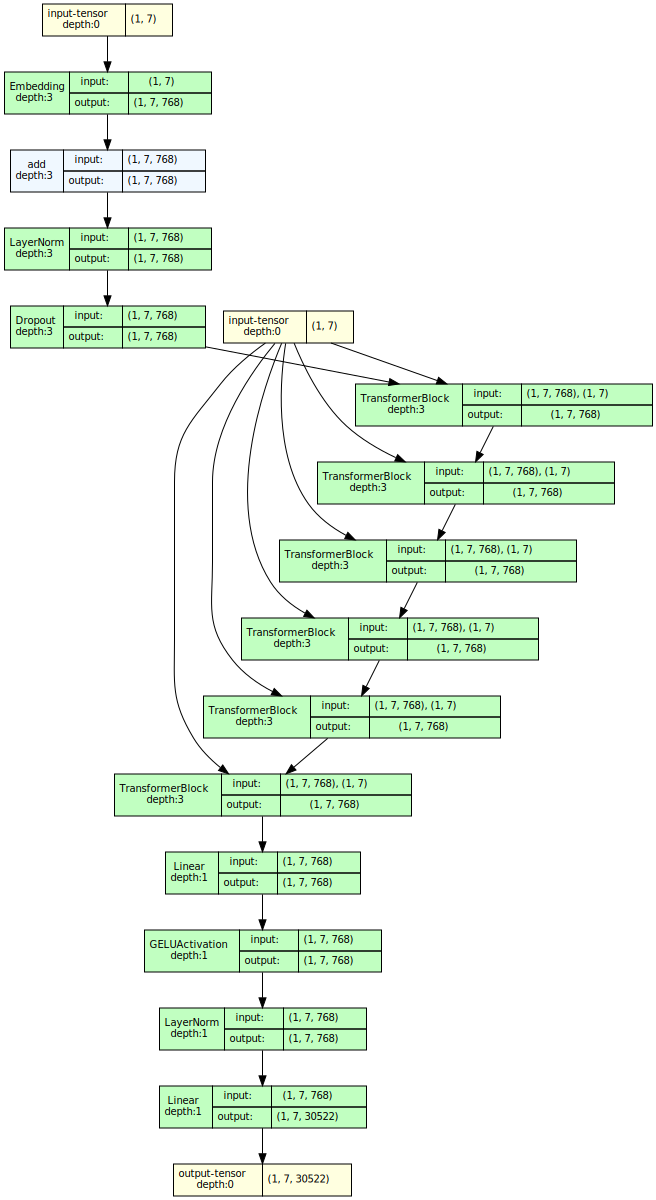

In [14]:
model_graph = draw_graph(model, input_data=tokenizer(TESTING_TEXT[0], return_tensors="pt").to('cuda'))
model_graph.resize_graph(20)
model_graph.visual_graph

In [15]:
PRODUCTS = [
  'gym wear', 'jackets', 'shirts',
  'running shoes', 'basketballs', 'caps', 'pants', 'socks',
  'trousers', 'training shoes', 'basketball shoes', 'shoes',
  'athletic wear', 'sports wear', 'footballs',
  'performance gear', 'hats', 'sweaters', 'tshirts', 'wristbands',
  'backpacks', 'tshirts', 'hoodies', 'trainers',
  'soccer shoes',
]

POSITIVE_SENTIMENT_ADJECTIVES = [
  'stylish', 'innovative', 'comfortable', 'durable', 'performance-oriented',
  'high-quality', 'fashionable', 'sporty', 'functional', 'lightweight',
  'breathable', 'flexible', 'athletic', 'modern', 'inexpensive', 'cheap',
  'trendsetting', "revolutionary", 'good-looking'
]

NEGATIVE_SENTIMENT_ADJECTIVES = [
  'uncomfortable', 'flimsy', 'poor quality', 'outdated', 'unfashionable',
  'heavy', 'inferior', 'unathletic', 'expensive', 'costly',
  'overpriced', 'defective', 'ugly', 'dirty', 'faulty'
]

ADJECTIVES = POSITIVE_SENTIMENT_ADJECTIVES + NEGATIVE_SENTIMENT_ADJECTIVES

PRODUCT_FEATURE_WORDS = list(set(
  ['comfort', 'fit', 'quality', 'style', 'durability', 'performance', 'design', 'look', 'support', 'flexibility', 'lightweight', 'breathability', 'cushioning', 'grip', 'stability', 'traction', 'bounce'] +
  POSITIVE_SENTIMENT_ADJECTIVES
))

COMPANIES = [
  # repeat a couple of times for higher positive examples
  'nike', 'nike', 'nike', 'nike', 'nike', 'nike', 'nike'
  'adidas', 'puma', 'under armour', 'new balance', 'reebok',
  'converse', 'vans', 'fila', 'asics'
]

JOINERS = [
  'are', 'is', 'offer', 'provide', 'feature', 'boast',
  'are known for being', 'are recognized for being', 'are famous for being',
  'are renowned for being', 'are praised for being',
]

In [16]:
def csv2json (csv_file_name, json_file_name, attrs={}):
  df = pd.read_csv(csv_file_name)
  data = []
  
  for _, row in df.iterrows():
    print(row.to_dict())
    data.append({
      'text': row['text'],
      'label': row['label']
    })
  
  json_data = attrs
  json_data.update({'data': data})

  with open(json_file_name, 'w') as f:
    json.dump(json_data, f)

def create_basic_brute_dataset(dataset_size):
  data = {
      "version": "0.1.0",
      "source": "sample",
      "url": "self-generated",
      "data": []
  }
  arr = []

  for idx in range(dataset_size):
    company = random.choice(COMPANIES)
    joiner = random.choice(JOINERS)
    product = random.choice(PRODUCTS)
    label = random.choice([0, 1])
    
    if label == 0:
      adjective = random.choice(NEGATIVE_SENTIMENT_ADJECTIVES)
    else:
      adjective = random.choice(POSITIVE_SENTIMENT_ADJECTIVES)
    
    sentence = f'{company} {product} {joiner} {adjective}'
    
    arr.append({
      "text": sentence,
      "label": label
    })
  
  data["data"] = arr
  return data

def save_dataset (dataset, save_file_name):
  with open(save_file_name, 'w') as f:
    json.dump(dataset, f)

In [17]:
SYNTHESIZED_DATASET_SIZE = 10000
uptrain_save_fold_name = "uptrain_smart_data_bert"
synthesized_data_csv = 'data.csv'
synthesized_data_file_name = 'data.json'

nike_products_dataset = {
  'version': "1.0.0",
  'source': "Product Data from Nike",
  'url': "https://data.world/data-hut/product-data-from-nike",
  'infile': "datasets/raw/nike_products.csv",
  'outfile': "datasets/cleaned/nike_products.json"
}

nike_customer_reviews_kaggle_dataset = {
  'version': "1.0.0",
  'source': "Nike Onlinestore Customer Reviews",
  'url': "https://www.kaggle.com/datasets/tinkuzp23/nike-onlinestore-customer-reviews",
  'infile': "datasets/raw/nike_customer_reviews_kaggle.csv",
  'outfile': "datasets/cleaned/nike_customer_reviews_kaggle.json"
}

products_kaggle_dataset = {
  'version': "1.0.0",
  'source': "Products: Prices, Descriptions, Reviews",
  'url': "https://www.kaggle.com/datasets/thedevastator/nike-usa-products-prices-descriptions-and-custom",
  'infile': "datasets/raw/products_kaggle.csv",
  'outfile': "datasets/cleaned/products_kaggle.json"
}

In [18]:
df = pd.DataFrame()

# Use the nike_products dataset and append it to our dataframe
nike_products_df = pd.read_csv(nike_products_dataset['infile'])
x = pd.DataFrame()
x['text'] = nike_products_df['Product Name'] + ' ' + nike_products_df['Description']
x.reset_index(drop=True, inplace=True)
x.to_json(nike_products_dataset['outfile'])
df = x

# Use the nike_customer_reviews dataset and append it to our dataframe
nike_customer_reviews_kaggle_df = pd.read_csv(nike_customer_reviews_kaggle_dataset['infile'])
x = pd.DataFrame()
x['text'] = nike_customer_reviews_kaggle_df['Title'] + ' ' + nike_customer_reviews_kaggle_df['Content']
x.reset_index(drop=True, inplace=True)
x.to_json(nike_customer_reviews_kaggle_dataset['outfile'])
df = df.append(x)

# Use the products_kaggle dataset and append it to our dataframe
products_kaggle_df = pd.read_csv(products_kaggle_dataset['infile'])
x = pd.DataFrame()
x['text'] = products_kaggle_df['name'] + ' ' + products_kaggle_df['description']
x.reset_index(drop=True, inplace=True)
x.to_json(products_kaggle_dataset['outfile'])
df = df.append(x)

df = df[df['text'].notna()]

# Replace all raw digits because they're most likely of no use in determining
# masked words
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))

# Remove all punctuation explicitly even though BERT probably does it
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Create our own dataset of reviews for different companies, products, etc.
brute_dataset = create_basic_brute_dataset(SYNTHESIZED_DATASET_SIZE)
brute_df = pd.DataFrame(brute_dataset['data'])
df = df.append(brute_df)

# Make everything lowercase since the model is uncased
df['text'] = df['text'].str.lower()

print(f'Dataset size: {len(df)}')
print(df)

df.reset_index(drop=True, inplace=True)
df.to_csv(synthesized_data_csv)
create_dataset_from_csv(synthesized_data_csv, 'text', synthesized_data_file_name)

with open(synthesized_data_file_name) as file:
  dataset = json.loads(file.read())

Dataset size: 10946
                                                   text  label
0     nike air force   essential let your shoe game ...    NaN
1     nike air force   the legend lives on in the ni...    NaN
2     nike air force  sage low lx taking both height...    NaN
3     nike air max dia se designed for a womans foot...    NaN
4     nike air max verona pass on the good vibes in ...    NaN
...                                                 ...    ...
9995               nike athletic wear boast fashionable    1.0
9996                  nike trousers feature inexpensive    1.0
9997                nike soccer shoes feature defective    0.0
9998                          nike shoes feature faulty    0.0
9999                   asics soccer shoes is breathable    1.0

[10946 rows x 2 columns]


In [19]:
def perform_training_and_testing (model, model_save_file_name, data_file_name, epochs):
  original_model_outputs = []
  retrained_model_outputs = []

  for text in TESTING_TEXT:
    original_model_outputs.append({
      'text': text,
      'tokens': top_k_tokens(model, text, TOP_K)
    })

  retrained_data = retrain_model(model, data_file_name, epochs, model_save_file_name)

  for text in TESTING_TEXT:
    retrained_model_outputs.append({
      'text': text,
      'tokens': top_k_tokens(model, text, TOP_K)
    })
  
  return original_model_outputs, retrained_model_outputs, retrained_data

def pretty_print_original_vs_retrained_outputs (original_model_outputs, retrained_model_outputs):
  for original, retrained in zip(original_model_outputs, retrained_model_outputs):
    print('                Text:', original['text'])
    print(' Original Top Tokens:', original['tokens'])
    print('Retrained Top Tokens:', retrained['tokens'])
    print()

In [22]:
model, tokenizer = get_model_and_tokenizer()

original_model_outputs, retrained_model_outputs, results_v1 = \
  perform_training_and_testing(model, model_save_file_name + '-v1', synthesized_data_file_name, epochs=5)

pretty_print_original_vs_retrained_outputs(original_model_outputs, retrained_model_outputs)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Is "cuda" available? True
Device: Tesla T4


  0%|          | 0/1 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 120
  Batch size = 64
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1077
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 85
  Number of trainable parameters = 66985530


Before Training Eval Results:
 {
  "eval_loss": 4.67988395690918,
  "eval_runtime": 0.6466,
  "eval_samples_per_second": 185.595,
  "eval_steps_per_second": 3.093
}
  Before Training Perplexity: 107.76


Step,Training Loss,Validation Loss
2,No log,3.906454
2,No log,3.794898
4,No log,3.563092
4,No log,3.403709
6,No log,3.367691
6,No log,3.418432
8,No log,3.133750
8,No log,3.123809
10,No log,2.939871
10,3.796500,2.811829


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1077
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 120
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1077
  Batch size = 64
The following columns in the evaluatio

After Training Eval Results:
 {
  "eval_loss": 1.9603054523468018,
  "eval_runtime": 0.6531,
  "eval_samples_per_second": 183.748,
  "eval_steps_per_second": 3.062,
  "epoch": 5.0
}
  After Training Perplexity: 7.10
                Text: Nike shoes are very [MASK]
 Original Top Tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top Tokens: ['expensive', 'comfortable', 'popular', 'durable', 'fashionable', 'costly', 'lightweight', 'uncomfortable', 'heavy', 'flexible']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top Tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare', 'sharp', 'strong', 'distinctive', 'elastic', 'attractive']
Retrained Top Tokens: ['durable', 'expensive', 'costly', 'fashionable', 'heavy', 'lightweight', 'flexible', 'innovative', 'athletic', 'popular']

                Text: Nike [MASK] shoes are very comfortable
 Original Top

In [23]:
vader_sia = SentimentIntensityAnalyzer()

def nike_text_present_func (inputs, outputs, gts=None, extra_args={}):
  is_present = []
  for input in inputs["text"]:
    is_present.append(bool("nike" in input.lower()))
  return is_present

def nike_product_keyword_func (inputs, outputs, gts=None, extra_args={}):
  is_present = []
  for input in inputs["text"]:
    input = input.lower()
    for word in PRODUCTS:
      if word in input:
        is_present.append(True)
        break
    else:
      is_present.append(False)
  return is_present

def is_positive_sentiment_func (inputs, outputs, gts=None, extra_args={}):
  is_positive = []
  for input in inputs["text"]:
    input = input.lower()
    positive = False
    
    if vader_sia.polarity_scores(input)["compound"] >= 0:
      for word in PRODUCT_FEATURE_WORDS:
        if word in input:
          positive = True
          break
    
    is_positive.append(positive)
  
  return is_positive

def content_length_func (inputs, outputs, gts=None, extra_args={}):
  lengths = []
  for input in inputs["text"]:
    lengths.append(len(input))
  return lengths

In [24]:
cfg = {
    'checks': [
      {
        'type': uptrain.Anomaly.EDGE_CASE,
        "signal_formulae": \
          uptrain.Signal("'Nike' text Present", nike_text_present_func) &
          uptrain.Signal("Is it a Nike product", nike_product_keyword_func) &
          uptrain.Signal("Is positive Sentiment", is_positive_sentiment_func)
      },

      {
        'type': uptrain.Anomaly.DATA_INTEGRITY,
        'measurable_args': {
          'type': uptrain.MeasurableType.INPUT_FEATURE,
          'feature_name': 'text'
        },
        'integrity_type': 'non_null'
      },

      {
        'type': uptrain.Anomaly.DATA_INTEGRITY,
        'measurable_args': {
          'type': uptrain.MeasurableType.CUSTOM,
          'signal_formulae': uptrain.Signal("content_length", content_length_func),
        },
        "integrity_type": "greater_than",
        "threshold": 256
      },

      {
        'type': uptrain.Anomaly.CONCEPT_DRIFT,
        'algorithm': uptrain.DataDriftAlgo.DDM
      }
    ],

    # Define where to save the retraining dataset
    'retraining_folder': uptrain_save_fold_name,
    
    # Define when to retrain, define a large number because we
    # are not retraining yet
    'retrain_after': 10000000000
}

framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data_bert


In [25]:
for index, sample in enumerate(dataset['data']):
  if index % 500 == 0:
    print(f'Processed {index} samples')
  inputs = {'data': {'text': [sample['text']]}}
  framework.log(inputs = inputs, outputs = None)

retraining_csv = uptrain_save_fold_name + '/1/smart_data.csv'
retraining_json = 'retrain_dataset.json'
create_dataset_from_csv(retraining_csv, 'text', retraining_json)

Processed 0 samples
Processed 500 samples
50  edge cases identified out of  826  total samples
Processed 1000 samples
100  edge cases identified out of  1099  total samples
150  edge cases identified out of  1274  total samples
200  edge cases identified out of  1492  total samples
Processed 1500 samples
250  edge cases identified out of  1669  total samples
300  edge cases identified out of  1849  total samples
Processed 2000 samples
350  edge cases identified out of  2025  total samples
400  edge cases identified out of  2198  total samples
450  edge cases identified out of  2367  total samples
Processed 2500 samples
500  edge cases identified out of  2507  total samples
550  edge cases identified out of  2740  total samples
600  edge cases identified out of  2899  total samples
Processed 3000 samples
650  edge cases identified out of  3095  total samples
700  edge cases identified out of  3261  total samples
750  edge cases identified out of  3428  total samples
Processed 3500 sampl

'retrain_dataset.json'

In [27]:
model, tokenizer = get_model_and_tokenizer()

original_model_outputs, retrained_model_outputs, results_v2 = \
  perform_training_and_testing(model, model_save_file_name + '-v2', retraining_json, epochs=25)

pretty_print_original_vs_retrained_outputs(original_model_outputs, retrained_model_outputs)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Is "cuda" available? True
Device: Tesla T4


  0%|          | 0/1 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 24
  Batch size = 64
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 211
  Num Epochs = 25
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 66985530


Before Training Eval Results:
 {
  "eval_loss": 4.28580379486084,
  "eval_runtime": 0.2035,
  "eval_samples_per_second": 117.927,
  "eval_steps_per_second": 4.914
}
  Before Training Perplexity: 72.66


Step,Training Loss,Validation Loss
2,No log,3.147176
2,No log,3.157563
4,No log,2.647243
4,No log,2.474576
6,No log,2.325419
6,No log,2.410182
8,No log,2.184188
8,No log,2.150027
10,No log,2.057662
10,2.947100,2.098443


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 211
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 24
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 211
  Batch size = 64
The following columns in the evaluation s

After Training Eval Results:
 {
  "eval_loss": 0.9722399115562439,
  "eval_runtime": 0.2044,
  "eval_samples_per_second": 117.426,
  "eval_steps_per_second": 4.893,
  "epoch": 25.0
}
  After Training Perplexity: 2.64
                Text: Nike shoes are very [MASK]
 Original Top Tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top Tokens: ['comfortable', 'expensive', 'fashionable', 'popular', 'durable', 'flexible', 'athletic', 'modern', 'lightweight', 'cheap']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top Tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare', 'sharp', 'strong', 'distinctive', 'elastic', 'attractive']
Retrained Top Tokens: ['durable', 'flexible', 'lightweight', 'fashionable', 'athletic', 'innovative', 'expensive', 'revolutionary', 'comfortable', 'modern']

                Text: Nike [MASK] shoes are very comfortable
 Orig

In [28]:
def get_loss_history (log_history):
  training_loss_history = []
  training_loss_steps = []
  eval_loss_history = []
  eval_loss_steps = []
  
  for history in log_history[:-2]:
    if 'train_loss' in history.keys():
      training_loss_history.append(history['train_loss'])
      training_loss_steps.append(history['step'])
    if 'eval_loss' in history.keys():
      eval_loss_history.append(history['eval_loss'])
      eval_loss_steps.append(history['step'])
  
  return (training_loss_steps, training_loss_history), (eval_loss_steps, eval_loss_history)

def get_perplexities (eval_loss_history):
  return list(map(math.exp, eval_loss_history))

In [29]:
trainer_v1 = results_v1[-1]
trainer_v2 = results_v2[-1]

v1_training_history, v1_eval_history = get_loss_history(trainer_v1.state.log_history)
v2_training_history, v2_eval_history = get_loss_history(trainer_v2.state.log_history)

v1_perplexities = get_perplexities(v1_eval_history[1])
v2_perplexities = get_perplexities(v2_eval_history[1])

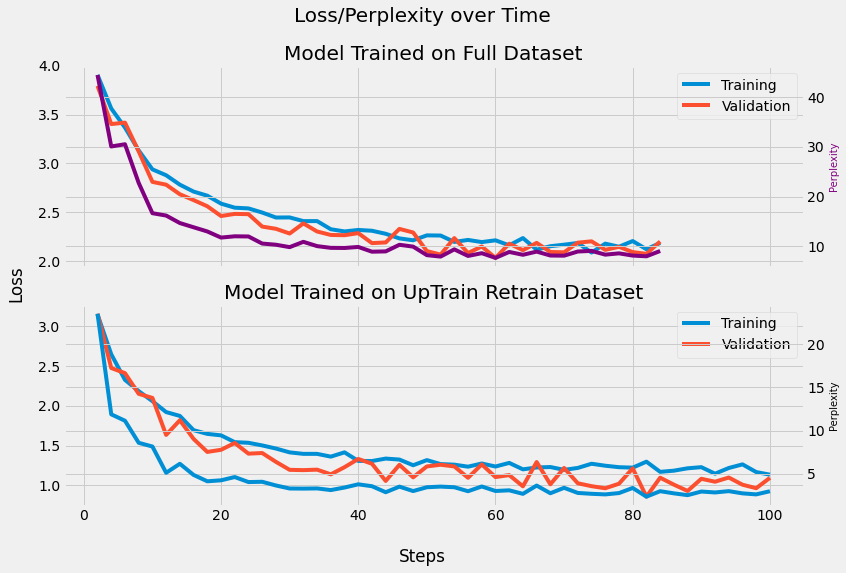

In [52]:
with plt.style.context('fivethirtyeight'):
  fig, axs = plt.subplots(2, 1, sharex = True)

  fig.set_size_inches(12, 8)
  fig.suptitle('Loss/Perplexity over Time', fontsize = 20)
  fig.supxlabel('Steps')
  fig.supylabel('Loss')

  axs[0].set_title('Model Trained on Full Dataset')
  axs[1].set_title('Model Trained on UpTrain Retrain Dataset')

  training_color = 'green'
  validation_color = 'red'
  axs[0].plot(*v1_training_history, label = 'Training', color = training_color)
  axs[0].plot(*v1_eval_history, label = 'Validation', color = validation_color)
  axs[1].plot(*v2_training_history, label = 'Training', color = training_color)
  axs[1].plot(*v2_eval_history, label = 'Validation', color = validation_color)

  color = 'purple'
  axs0twin = axs[0].twinx()
  axs0twin.set_ylabel('Perplexity', fontsize = 10, color = color)
  axs0twin.plot(v1_eval_history[0], v1_perplexities, label = 'Perplexity', color = color)
  axs0twin.tick_params(axis='y', color = color)

  axs1twin = axs[1].twinx()
  axs1twin.set_ylabel('Perplexity', fontsize = 10, color = color)
  axs1twin.plot(v2_eval_history[0], v2_perplexities, label = 'Perplexity', color = color)
  axs1twin.tick_params(axis='y', color = color)

  axs[0].legend()
  axs[1].legend()

  fig.subplots_adjust(top=1)
  fig.tight_layout()

  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/uptrain
!ls

In [ ]:
!cp -r data.csv distilbert-base-uncased-finetuned-uptrain distilbert-base-uncased-finetuned-customer-product-support-v1 distilbert-base-uncased-finetuned-customer-product-support-v2 uptrain_smart_data_bert data.json datasets retrain_dataset.json /content/drive/MyDrive/uptrain

In [ ]:
# https://huggingface.co/course/chapter7/3

# retrain_dataset = load_dataset('json', data_files={"train": synthesized_data_file_name}, field='data')
# tokenized_datasets = retrain_dataset.map(
#   tokenize_function, batched=True, remove_columns=["text", "label"]
# )

# lm_datasets = tokenized_datasets.map(group_texts, batched=True)
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mlm_probability)

# downsampled_dataset = lm_datasets["train"].train_test_split(
#   train_size=train_size, test_size=test_size,# seed=42
# )

# # Show the training loss with every epoch
# logging_steps = len(downsampled_dataset["train"]) // batch_size

# def insert_random_mask(batch):
#   features = [dict(zip(batch, t)) for t in zip(*batch.values())]
#   masked_inputs = data_collator(features)
#   return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

# downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
# eval_dataset = downsampled_dataset["test"].map(
#     insert_random_mask,
#     batched=True,
#     remove_columns=downsampled_dataset["test"].column_names,
# )
# eval_dataset = eval_dataset.rename_columns(
#   {
#     "masked_input_ids": "input_ids",
#     "masked_attention_mask": "attention_mask",
#     "masked_labels": "labels",
#   }
# )

# train_dataloader = DataLoader(
#   downsampled_dataset["train"],
#   shuffle=True,
#   batch_size=batch_size,
#   collate_fn=data_collator,
# )
# eval_dataloader = DataLoader(
#   eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
# )

# optimizer = AdamW(model.parameters(), lr=5e-5)

# accelerator = Accelerator()
# model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
#   model, optimizer, train_dataloader, eval_dataloader
# )

# num_train_epochs = 5
# num_update_steps_per_epoch = len(train_dataloader)
# num_training_steps = num_train_epochs * num_update_steps_per_epoch

# lr_scheduler = get_scheduler(
#   "linear",
#   optimizer=optimizer,
#   num_warmup_steps=0,
#   num_training_steps=num_training_steps,
# )

# progress_bar = tqdm(range(num_training_steps))

# for epoch in range(num_train_epochs):
#     # Training
#     model.train()
#     for batch in train_dataloader:
#         outputs = model(**batch)
#         loss = outputs.loss
#         accelerator.backward(loss)

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     # Evaluation
#     model.eval()
#     losses = []
#     for step, batch in enumerate(eval_dataloader):
#         with torch.no_grad():
#             outputs = model(**batch)

#         loss = outputs.loss
#         losses.append(accelerator.gather(loss.repeat(batch_size)))

#     losses = torch.cat(losses)
#     losses = losses[: len(eval_dataset)]
#     try:
#         perplexity = math.exp(torch.mean(losses))
#     except OverflowError:
#         perplexity = float("inf")

#     print(f">>> Epoch {epoch}, Perplexity: {perplexity}")

#     accelerator.wait_for_everyone()
#     unwrapped_model = accelerator.unwrap_model(model)
#     unwrapped_model.save_pretrained(uptrain_save_fold_name, save_function=accelerator.save)
#     if accelerator.is_main_process:
#         tokenizer.save_pretrained(uptrain_save_fold_name)

In [ ]:
# for index, sample in enumerate(all_data['data']):
#   if index % 250 == 0:
#     print(f'Sample: {index}')
#   inputs = {'data': {'text': [sample['text']]}}
#   framework.log(inputs = inputs, outputs = None)

# retraining_csv = uptrain_save_fold_name + '/1/smart_data.csv'
# retraining_json = 'retrain_dataset.json'
# csv2json(retraining_csv, retraining_json)

In [ ]:
# retrain_model(model, retraining_dataset)
# retrained_model_outputs = test_model(model, testing_text)